In [2]:

import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('data1/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


data1/data.csv


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

2022-08-19 12:08:31.703986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-19 12:08:31.704011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Visualtisation de la data

In [4]:
df=pd.read_csv("data1/data.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [5]:
df.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,kennedy questions trust of blair lib dem leade...
freq,511,2


In [6]:
df.dtypes

category    object
text        object
dtype: object

In [7]:
df['category'].nunique()

5

In [8]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

/home/anouar/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


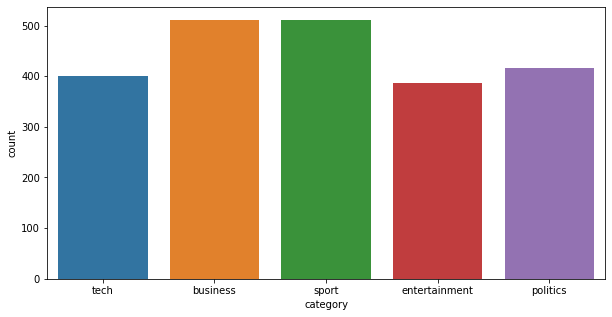

In [9]:
#sns.countplot(df['category'])
# plote the count of each category
plt.figure(figsize=(10,5))
sns.countplot(df['category'])
plt.show()

In [10]:
df['text'][5]

'howard hits back at mongrel jibe michael howard has said a claim by peter hain that the tory leader is acting like an  attack mongrel  shows labour is  rattled  by the opposition.  in an upbeat speech to his party s spring conference in brighton  he said labour s campaigning tactics proved the tories were hitting home. mr hain made the claim about tory tactics in the anti-terror bill debate.  something tells me that someone  somewhere out there is just a little bit rattled   mr howard said. mr hain  leader of the commons  told bbc radio four s today programme that mr howard s stance on the government s anti-terrorism legislation was putting the country at risk. he then accused the tory leader of behaving like an  attack mongrel  and  playing opposition for opposition sake .  mr howard told his party that labour would  do anything  say anything  claim anything to cling on to office at all costs .  so far this year they have compared me to fagin  to shylock and to a flying pig. this mor

In [11]:
df.isnull().sum()

category    0
text        0
dtype: int64

# CLEANING

In [12]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = symbols.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [13]:
df['text']=df['text'].apply(clean_text)

In [14]:
df['text'][5]

'howard hits back mongrel jibe michael howard said claim peter hain tory leader acting like attack mongrel shows labour rattled opposition upbeat speech party spring conference brighton said labour campaigning tactics proved tories hitting home mr hain made claim tory tactics antiterror bill debate something tells someone somewhere little bit rattled mr howard said mr hain leader commons told bbc radio four today programme mr howard stance government antiterrorism legislation putting country risk accused tory leader behaving like attack mongrel playing opposition opposition sake mr howard told party labour would anything say anything claim anything cling office costs far year compared fagin shylock flying pig morning peter hain even called mongrel know something tells someone somewhere little bit rattled environment secretary margaret beckett rejected mr howard comment telling radio 4 pm programme labour rattled real duty try get people focus michael howard record proposals trying put 

In [15]:
df['text'][20]

'security warning fbi virus us federal bureau investigation warning computer virus spread via emails purport fbi emails show come fbigov address tell recipients accessed illegal websites messages warn internet use monitored fbi internet fraud complaint center attachment email contains virus fbi said message asks recipients click attachment answer questions internet use rather questionnaire attachment contains virus infects recipient computer according agency clear virus infected computer users warned never open attachment unsolicited emails people know recipients similar solicitations know fbi engage practice sending unsolicited emails public manner fbi said statement bureau investigating phoney emails agency earlier month shut fbigov accounts used communicate public security breach spokeswoman said two incidents appear unrelated'

In [16]:
g=[]
for i in df['text']:
    g.append(i)

len(g)

2225

In [17]:
len(g[4])

1207

In [18]:
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 16201


# longueur maximale de rembourrage

In [19]:
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 32485 unique tokens.


# Comme la longueur maximale de la séquence est grande, nous sélectionnerons une longueur maximale de 1200.

In [20]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=1200)

In [21]:
X.shape

(2225, 1200)

In [22]:
Y = pd.get_dummies(df['category'],columns=df["category"]).values
Y

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [23]:
len(Y)

2225

In [29]:
df.head(3)

,category,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...


In [30]:
df.tail(3)

,category,text
2222,entertainment,rem announce new glasgow concert us band rem a...
2223,politics,political squabbles snowball become commonplac...
2224,sport,souness delight euro progress boss graeme soun...


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2002, 1200) (2002, 5)
(223, 1200) (223, 5)


# MODEL

In [32]:
model=Sequential()
model.add(Embedding(50000,100,input_length=1200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-08-19 12:08:37.723198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-19 12:08:37.723232: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-19 12:08:37.723258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anouar): /proc/driver/nvidia/version does not exist
2022-08-19 12:08:37.723843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1200, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=128,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
15/15 [==============================] - 38s 2s/step - loss: 1.6007 - accuracy: 0.2537 - val_loss: 1.5709 - val_accuracy: 0.4378
Epoch 2/10
15/15 [==============================] - 44s 3s/step - loss: 1.4945 - accuracy: 0.3976 - val_loss: 1.3113 - val_accuracy: 0.4726
Epoch 3/10
15/15 [==============================] - 43s 3s/step - loss: 1.1159 - accuracy: 0.5114 - val_loss: 1.0826 - val_accuracy: 0.4577
Epoch 4/10
15/15 [==============================] - 43s 3s/step - loss: 0.9071 - accuracy: 0.6918 - val_loss: 0.8756 - val_accuracy: 0.8159
Epoch 5/10
15/15 [==============================] - 47s 3s/step - loss: 0.5384 - accuracy: 0.9178 - val_loss: 0.4245 - val_accuracy: 0.8806
Epoch 6/10
15/15 [==============================] - 45s 3s/step - loss: 0.2003 - accuracy: 0.9750 - val_loss: 0.1628 - val_accuracy: 0.9701
Epoch 7/10
15/15 [==============================] - 42s 3s/step - loss: 0.1606 - accuracy: 0.9628 - val_loss: 0.1715 - val_accuracy: 0.9751
Epoch 8/10
15/15 [==

In [35]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 2s 240ms/step - loss: 0.2715 - accuracy: 0.9327
Test set
  Loss: 0.271
  Accuracy: 0.933


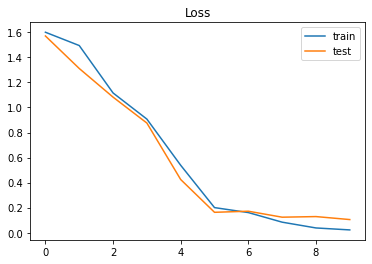

In [36]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

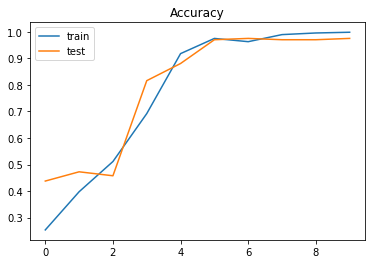

In [37]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [38]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [45]:
new_complaint = ['Cricket Australia is set to begin the team’s pre-season later this month under a set of new training protocols devised for the safety of players amid the COVID-19 pandemic.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=1200)
pred = model.predict(padded)
labels = ['Business','Entertainment','Politics','Sports','Tech']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 123ms/step
[[0.00663049 0.00137342 0.97223604 0.01876264 0.00099742]] Politics
